In [1]:
# Importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os
import cv2
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import PIL
from PIL import Image

import keras

Using TensorFlow backend.


In [2]:
# Importing the datasets

train_dir = "C:\\Users\\SRIRAM\\Desktop\\Training"
test_dir = "C:\\Users\\SRIRAM\\Desktop\\Test"

# There are two classes present in the dataset. The exact counts of the data are shown using the command below.

In [3]:
# Getting the count of training images

cat_counts = {}
for cat in os.listdir(train_dir):
    counts = len(os.listdir(os.path.join(train_dir, cat)))
    cat_counts[cat] =counts
print(cat_counts)

{'Fire': 25018, 'No_Fire': 14357}


In [4]:
# Getting the count of test images

cat_counts = {}
for cat in os.listdir(test_dir):
    counts = len(os.listdir(os.path.join(test_dir, cat)))
    cat_counts[cat] =counts
print(cat_counts)

{'Fire': 5137, 'No_Fire': 3480}


# Data Pre-processing steps

In [5]:
# Data Preprocessing
#Image Data Generator
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,   # Stretches and slant the image to a particular angle
                                   rotation_range = 40, # randomly rotates the image so that the model become inavariant to object orientation
                                   zoom_range = 0.2,    #randomly zoom-in or zoom-out the image
                                   brightness_range = [0.8, 1.2], #range changes the brightness of the image
                                   horizontal_flip = True,     #randomly flips the image horizontally
                                   fill_mode = 'nearest',
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2
                                   ) 

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('C:\\Users\\SRIRAM\\Desktop\\Training',
                                                  target_size = (224, 224),
                                                  batch_size = 32,
                                                  class_mode = 'binary', shuffle = True)

test_set = test_datagen.flow_from_directory('C:\\Users\\SRIRAM\\Desktop\\Test',
                                             target_size = (224, 224),
                                             batch_size = 32,
                                             class_mode = 'binary')

Found 39375 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [6]:
#Finding the class Index
training_set.class_indices

{'Fire': 0, 'No_Fire': 1}

# Class_weight method is used to balance the data. The dataset is slightly imbalanced. In order to balance the dataset, this method is being adopted.

In [7]:
# Utilizing Class_weight to balance the training data class labels

from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(training_set.classes), 
                training_set.classes) 

class_weights = dict(enumerate(class_weights))

C:\Users\SRIRAM\anaconda3\envs\gputest\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [8]:
# Printing the evaluated class_weights

class_weights

{0: 0.7869334079462786, 1: 1.371282301316431}

In [9]:
#Importing required libraries
from keras.layers import Dropout
from keras import models, regularizers, layers, optimizers, losses, metrics

from keras.layers import GlobalAveragePooling2D
from keras.layers import GaussianNoise

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.utils import np_utils

# Downloading the VGG19 model for the model

In [10]:
# Importing the VGG19 required libraries

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

vgg_base = VGG19(weights='imagenet',    
                 include_top=False,     
                 input_shape=(224, 224, 3))
print(vgg_base.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Fine tuning involves in freezing some layers of the transfer learning method and adding our own set of layers for better results.

In [11]:
# Fine tuning the model
trainable = False

for layer in vgg_base.layers:
    if layer.name == 'block5_conv2':
        trainable = True
        
    layer.trainable = trainable
    
print(vgg_base.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
# Builing the model

def build_model():
    from tensorflow.keras.optimizers import Adam, RMSprop
           
    model = keras.models.Sequential([vgg_base,
                                     keras.layers.Flatten(),
                                     keras.layers.Dropout(0.50),
                                     keras.layers.Dense(1, activation='sigmoid')])
    
    
    # Compiling the model

    model.compile(optimizer=RMSprop(lr = 1e-4), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [13]:
model = build_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 7,104,513
Non-trainable params: 12,944,960
_________________________________________________________________
None


In [14]:
# Calculating the steps per epoch parameter

BATCH_SIZE = 32
train_steps = training_set.n // BATCH_SIZE
test_steps = test_set.n // BATCH_SIZE

train_steps, test_steps

(1230, 269)

In [15]:
# Using the Callback

callback = keras.callbacks.EarlyStopping(
    monitor = "accuracy",
    min_delta = 0,
    patience = 3,
    verbose = 1,
    mode = "auto",
    baseline = None,
    restore_best_weights = False
)

In [16]:
# Model Training

history = model.fit_generator(
    training_set,
    steps_per_epoch=train_steps, class_weight = class_weights,
    epochs=100, callbacks = [callback]
    )

Epoch 1/100
1230/1230 [==============================] - 489s 397ms/step - loss: 0.0849 - accuracy: 0.9730
Epoch 2/100
1230/1230 [==============================] - 460s 374ms/step - loss: 0.0555 - accuracy: 0.9858
Epoch 3/100
1230/1230 [==============================] - 462s 376ms/step - loss: 0.0572 - accuracy: 0.9866
Epoch 4/100
1230/1230 [==============================] - 463s 376ms/step - loss: 0.0550 - accuracy: 0.9891
Epoch 5/100
1230/1230 [==============================] - 464s 377ms/step - loss: 0.0509 - accuracy: 0.9898
Epoch 6/100
1230/1230 [==============================] - 476s 387ms/step - loss: 0.0571 - accuracy: 0.9900
Epoch 7/100
1230/1230 [==============================] - 473s 385ms/step - loss: 0.0619 - accuracy: 0.9897
Epoch 8/100
1230/1230 [==============================] - 482s 392ms/step - loss: 0.0594 - accuracy: 0.9905
Epoch 9/100
1230/1230 [==============================] - 737s 599ms/step - loss: 0.0586 - accuracy: 0.9908
Epoch 10/100
1230/1230 [=============

# Testing the model using a sample test data

In [19]:
# Testing the model with a sample image 

import numpy as np
from keras.preprocessing import image

test_image = image.load_img('C:\\Users\\SRIRAM\\Desktop\\Test\\No_Fire\\resized_test_nofire_frame27.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
test_image = test_image / 255.0
result = model.predict(test_image)
training_set.class_indices
if result < 0.5:
    print('Fire')
else:
    print('No Fire')

No Fire


# Plotting the model performance 

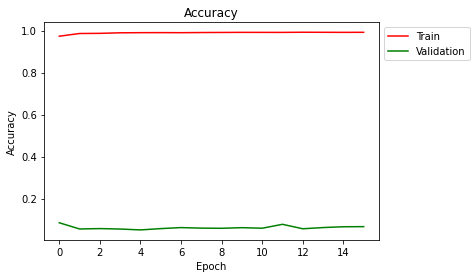

In [21]:
plt.plot(model.history.history['accuracy'],c='red')
plt.plot(model.history.history['loss'],c='green')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left', bbox_to_anchor = (1,1))

In [22]:
# Finding the metrics of the model

model.metrics_names

['loss', 'accuracy']

In [23]:
acc = history.history['accuracy']
loss = history.history['loss']


Text(0.5, 1.0, 'Training and Loss')

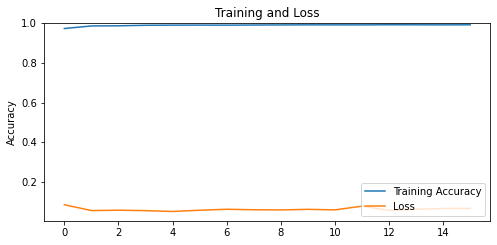

In [24]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy')

plt.plot(loss, label='Loss')

plt.legend(loc='lower right')

plt.ylabel('Accuracy')

plt.ylim([min(plt.ylim()),1])

plt.title('Training and Loss')